In [8]:
%matplotlib inline
import torch as tc
import tensorflow as tf
import mxnet as mx
from mxnet import np as mxnp
from mxnet import npx as npx
npx.set_np()
# import numpy as np

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

tc.__version__,tf.__version__,mx.__version__

('1.6.0', '2.3.1', '1.7.0')

In [2]:
import math
from mxnet.gluon import nn,rnn
from mxnet import init,gluon,autograd

## Seq2Seq Model

In [3]:
class Encoder(nn.Block):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    def forward(self,X,*args):
        raise NotImplementedError

In [4]:
class Decoder(nn.Block):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    def init_state(self,enc_outputs,*args):
        raise NotImplementedError
    def forward(self,X,state):
        raise NotImplementedError

In [5]:
class EncoderDecoder(nn.Block):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder=encoder
        self.decoder=decoder
    def forward(self,enc_x,dec_x,*args):
        enc_outputs=self.encoder(enc_x,*args)
        dec_state=self.decoder.init_state(enc_outputs,*args)
        return self.decoder(dec_x,dec_state)

In [6]:
class Seq2SeqEncoder(Encoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,bidirectional=True,dropout=0,**kwargs):
        super().__init__(**kwargs)
        self.embedding=nn.Embedding(vocab_size,embed_size)
        self.rnn=rnn.GRU(hidden_size=num_hiddens,num_layers=num_layers,bidirectional=bidirectional,dropout=dropout)
    def forward(self,X, *args): #X (bs,num_steps)
        X=self.embedding(X) #(bs,num_steps,embed_size)
        X=X.swapaxes(0,1)   #(num_steps,bs,embed_size)
        # In RNN models, the first axis corresponds to time steps
        state=self.rnn.begin_state(batch_size=X.shape[1],ctx=X.ctx)
        # `output` shape:   (`num_steps` , `batch_size`, `num_hiddens`),  If `bidirectional` is True, output shape will instead be `(sequence_length, batch_size, 2*num_hidden)`
        # `state[0]` shape: (`num_layers`, `batch_size`, `num_hiddens`),  If `bidirectional` is True, shape will instead be `(2*num_layers, batch_size, num_hidden)`.
        output,state=self.rnn(X,state)
        if self.rnn._dir==2: # 说明是双向网络
            #需要对state的前向、后向进行连接处理
            s=state[0] #(2*num_layers, batch_size, num_hidden)
            fwd=s[0:s.shape[0]:2]  #s[start:end:step]   #从start开始,以step为步长直到end结束。
            bwd=s[1:s.shape[0]:2]
            s=mxnp.concatenate([fwd,bwd],axis=-1) # (num_layers, batch_size, 2*num_hidden)
            state=(s,)
        # output (sequence_length, batch_size, _bir*num_hidden)
        # state:tuple (s,) 其中s (num_layers,      batch_size, _bir*num_hidden)
        return output,state

In [9]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,num_layers=3,bidirectional=True)
encoder.initialize()
X = mxnp.zeros((4, 7))
output, state = encoder(X)
output.shape,state[0].shape

((7, 4, 32), (3, 4, 32))

### --参考网址和代码

https://d2l.ai/chapter_recurrent-modern/seq2seq.html

https://bastings.github.io/annotated_encoder_decoder/

http://ethen8181.github.io/machine-learning/deep_learning/seq2seq/2_torch_seq2seq_attention.html#Encoder

https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/DecoderRNN.py

https://github.com/A-Jacobson/minimal-nmt/blob/master/nmt_tutorial.ipynb

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py

In [10]:
class Seq2SeqDecoder(Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0.1,bidirectional_encoder=True, **kwargs):
        super().__init__(**kwargs)
        if bidirectional_encoder:
            num_hiddens*=2 
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.GRU(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1] #返回的是hidden_state

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).swapaxes(0, 1)
        # `context` shape: (`batch_size`, `num_hiddens`)
        context = state[0][-1]
        #print(f"context.shape:{context.shape}")
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = mxnp.broadcast_to(context, (X.shape[0], context.shape[0], context.shape[1]))
        X_and_context = mxnp.concatenate((X, context), 2)  # X_and_context shape: `num_steps`, `batch_size`, (embed_size + bi*num_hiddens)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).swapaxes(0, 1)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state[0]` shape: (`num_layers`, `batch_size`, `bidirectional*num_hiddens`)
        return output, state

In [20]:
def masked_softmax(X,valid_len):
    """Perform softmax by filtering out some elements."""
    # X: 3-D tensor, valid_len: 1-D or 2-D tensor
    if valid_len is None:
        return npx.softmax(X)
    else:
        shape=X.shape
        if valid_len.ndim==1:
            valid_len=valid_len.repeat(shape[1],axis=0)
        else:
            valid_len=valid_len.reshape(-1)
        # Fill masked elements with a large negative, whose exp is 0
        X=npx.sequence_mask(X.reshape(-1,shape[-1]),valid_len,True,axis=1,value=-1e6)
        return npx.softmax(X).reshape(shape)

In [21]:
class DotProductAttention(nn.Block):
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    # `query`: (`batch_size`, #queries,  `d`)
    # `key`:   (`batch_size`, #kv_pairs, `d`)
    # `value`: (`batch_size`, #kv_pairs, `dim_v`)
    # `valid_len`: either (`batch_size`, ) or (`batch_size`, (`batch_size`* #queries))
    def forward(self, query, key, value, valid_len=None):
        d = query.shape[-1]
        # Set transpose_b=True to swap the last two dimensions of key
        scores = npx.batch_dot(query, key, transpose_b=True) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_len))
        return npx.batch_dot(attention_weights, value)

In [22]:
class MLPAttention(nn.Block):
    def __init__(self,hidden_units,dropout,**kwargs):
        super().__init__(**kwargs)
        # Use flatten=False to keep query's and key's 3-D shapes
        self.W_q=nn.Dense(hidden_units,use_bias=False,flatten=False)
        self.W_k=nn.Dense(hidden_units,use_bias=False,flatten=False)
        self.v=nn.Dense(1,use_bias=False,flatten=False)
        self.dropout=nn.Dropout(dropout)

    def forward(self,query,key,value,valid_len):
        query=self.W_q(query)
        key  =self.W_k(key)
        # Expand query to (`batch_size`, #queries, 1,  units),
        #    and  key  to (`batch_size`, 1, #kv_pairs, units). Then plus them with broadcast
        feature_q=mxnp.expand_dims(query,axis=2)
        feature_k=mxnp.expand_dims(key,axis=1)
        features=feature_q+feature_k
        features=mxnp.tanh(features)
        scores=self.v(features)
        scores=mxnp.squeeze(scores,axis=-1)
        attention_weights=self.dropout(masked_softmax(scores, valid_len))
        return npx.batch_dot(attention_weights, value)

In [25]:
class Seq2SeqAttentionDecoder(Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0.1,bidirectional_encoder=True, **kwargs):
        super().__init__(**kwargs)
        if bidirectional_encoder:
            num_hiddens*=2 
        self.attention_cell = MLPAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.GRU(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, enc_valid_len, *args):
        #return enc_outputs[1] #返回的是hidden_state 没有attention之前的
        outputs, hidden_state = enc_outputs
        # Transpose `outputs` to (`batch_size`, `seq_len`, `num_hiddens`)
        return (outputs.swapaxes(0, 1), hidden_state, enc_valid_len)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_len = state
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).swapaxes(0, 1)
        outputs = []
        for x in X: # along `num_steps`,During the decoding, the decoder output from the previous time step  t−1  is used as the query
            # `query` shape: (`batch_size`, 1, `num_hiddens`)
            query = mxnp.expand_dims(hidden_state[0][-1], axis=1)
            # `context` has same shape as `query`
            context = self.attention_cell(query, enc_outputs, enc_outputs, enc_valid_len) #query,key,value,valid_len
            # Concatenate on the feature dimension
            x = mxnp.concatenate((mxnp.expand_dims(x, axis=1),context), axis=-1)
            # Reshape `x` to (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.swapaxes(0, 1), hidden_state)
            outputs.append(out)
        outputs = mxnp.concatenate(outputs, axis=0)
        outputs = self.dense(outputs)
        return outputs.swapaxes(0, 1), [enc_outputs, hidden_state, enc_valid_len]    
            
        
        
#         # 没有attention之前的

#         # `context` shape: (`batch_size`, `num_hiddens`)
#         context = state[0][-1]
#         #print(f"context.shape:{context.shape}")
#         # Broadcast `context` so it has the same `num_steps` as `X`
#         context = mxnp.broadcast_to(context, (X.shape[0], context.shape[0], context.shape[1]))
#         X_and_context = mxnp.concatenate((X, context), 2)  # X_and_context shape: `num_steps`, `batch_size`, (embed_size + bi*num_hiddens)
#         output, state = self.rnn(X_and_context, state)
#         output = self.dense(output).swapaxes(0, 1)
#         # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
#         # `state[0]` shape: (`num_layers`, `batch_size`, `bidirectional*num_hiddens`)
#         return output, state

In [26]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.initialize()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.initialize()
X = mxnp.zeros((4, 7))
state = decoder.init_state(encoder(X), None)
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

((4, 7, 10), 3, (4, 7, 32), 1, (2, 4, 32))

In [28]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2,bidirectional=False)
encoder.initialize()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2,bidirectional_encoder=False)
decoder.initialize()
X = mxnp.zeros((4, 7))
state = decoder.init_state(encoder(X), None)
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

((4, 7, 10), 3, (4, 7, 16), 1, (2, 4, 16))

In [114]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,num_layers=3)
decoder.initialize()
enc_state=encoder(X)
print(len(enc_state))
state = decoder.init_state(enc_state)
print(state[0].shape)
print(state[0][-1].shape)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape

2
(3, 4, 32)
(4, 32)


((4, 7, 10), 1, (3, 4, 32))

In [115]:
en_decoder=EncoderDecoder(encoder,decoder)

In [116]:
output, state = en_decoder(X,X)
output.shape, len(state), state[0].shape

((4, 7, 10), 1, (3, 4, 32))

In [29]:
# encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
# decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)

def build_encoder_decoder(src_vocab_size,tgt_vocab_size,embed_size,num_hiddens,num_layers,bidirectional_encoder=True,dropout=0,ctx=mxd2l.try_gpu(),with_att=True,**kwargs):
    encoder=Seq2SeqEncoder(src_vocab_size, embed_size, num_hiddens, num_layers,bidirectional=bidirectional_encoder,dropout=dropout,**kwargs)
    DecoderModel=Seq2SeqAttentionDecoder if with_att else Seq2SeqDecoder
    decoder=DecoderModel(tgt_vocab_size, embed_size, num_hiddens, num_layers,bidirectional_encoder=bidirectional_encoder,dropout=dropout, **kwargs)
    en_decoder=EncoderDecoder(encoder,decoder)
    #en_decoder.initialize()
    en_decoder.initialize(init.Xavier(), force_reinit=True, ctx=ctx)
    return en_decoder

In [40]:
# en_decoder=build_encoder_decoder(100,256,128)
en_decoder=build_encoder_decoder(src_vocab_size=51,tgt_vocab_size=101, embed_size=80, num_hiddens=32,num_layers=8,bidirectional_encoder=False,with_att=True)

In [41]:
X=X.as_in_ctx(mxd2l.try_gpu())
output, state = en_decoder(X,X,None)
X.shape,output.shape, state[0].shape
# `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
# # `state[0]` shape: (`num_layers`, `batch_size`, `bidirectional*num_hiddens`)

((4, 7), (4, 7, 101), (4, 7, 32))

In [37]:
en_decoder=build_encoder_decoder(src_vocab_size=51,tgt_vocab_size=101, embed_size=80, num_hiddens=32,num_layers=8,bidirectional_encoder=False,with_att=False)
X=X.as_in_ctx(mxd2l.try_gpu())
output, state = en_decoder(X,X,None)
X.shape,output.shape, state[0].shape
# `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
# # `state[0]` shape: (`num_layers`, `batch_size`, `bidirectional*num_hiddens`)

((4, 7), (4, 7, 101), (8, 4, 32))

In [44]:
en_decoder=build_encoder_decoder(src_vocab_size=51,tgt_vocab_size=101, embed_size=80, num_hiddens=32,num_layers=8,bidirectional_encoder=True,with_att=True)
output, state = en_decoder(X,X,None)
X.shape,output.shape, state[0].shape
# `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
# # `state[0]` shape: (`num_layers`, `batch_size`, `bidirectional*num_hiddens`)

((4, 7), (4, 7, 101), (4, 7, 64))

In [45]:
len(state) #[enc_outputs, hidden_state,enc_valid_len]

3

In [42]:
en_decoder=build_encoder_decoder(src_vocab_size=51,tgt_vocab_size=101, embed_size=80, num_hiddens=32,num_layers=8,bidirectional_encoder=True,with_att=False)
X=X.as_in_ctx(mxd2l.try_gpu())
output, state = en_decoder(X,X,None)
X.shape,output.shape, state[0].shape
# `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
# # `state[0]` shape: (`num_layers`, `batch_size`, `bidirectional*num_hiddens`)

((4, 7), (4, 7, 101), (8, 4, 64))

In [43]:
len(state)

1

## MaskedSoftmaxCELoss

In [46]:
class MaskedSoftmaxCELoss(gluon.loss.SoftmaxCELoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self,pred,label,valid_len):
        weights=mxnp.expand_dims(mxnp.ones_like(label),axis=-1)         ## `weights` shape: (`batch_size`, `num_steps`, 1)
        weights = npx.sequence_mask(weights, valid_len, True, axis=1)   ## `weights` shape: (`batch_size`, `num_steps`, 1)，shape保持不变
        return super().forward(pred, label, weights)

In [47]:
X=mxnp.array([[1,2,3],[4,5,6]])
X

array([[1., 2., 3.],
       [4., 5., 6.]])

In [48]:
npx.sequence_mask(X,mxnp.array([2,1]),use_sequence_length=True,axis=1)

array([[1., 2., 0.],
       [4., 0., 0.]])

In [49]:
X = mxnp.ones((2, 3, 4))
npx.sequence_mask(X, mxnp.array([1, 2]), True, value=0, axis=1)

array([[[1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.]]])

In [50]:
X=mxnp.array([[1,2,3],[4,5,6]])
X

array([[1., 2., 3.],
       [4., 5., 6.]])

In [51]:
weights=mxnp.expand_dims(mxnp.ones_like(X),axis=-1)
weights.shape,weights

((2, 3, 1),
 array([[[1.],
         [1.],
         [1.]],
 
        [[1.],
         [1.],
         [1.]]]))

In [52]:
weights2 = npx.sequence_mask(weights, mxnp.array([2,1]), True, axis=1)
weights2.shape,weights2

((2, 3, 1),
 array([[[1.],
         [1.],
         [0.]],
 
        [[1.],
         [0.],
         [0.]]]))

In [53]:
loss = MaskedSoftmaxCELoss()
loss(mxnp.ones((3, 4, 10)), mxnp.ones((3, 4)), mxnp.array([4, 2, 0]))

array([2.3025851, 1.1512926, 0.       ])

In [54]:
def train_s2s_ch9(model, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence (defined in Chapter 9)."""
    np=mxnp
    #model.initialize(init.Xavier(), force_reinit=True, ctx=device)
    trainer = gluon.Trainer(model.collect_params(), 'adam',
                            {'learning_rate': lr})
    loss = MaskedSoftmaxCELoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [
                x.as_in_ctx(device) for x in batch]
            bos = np.array(
                [tgt_vocab['<bos>']] * Y.shape[0], ctx=device).reshape(-1, 1)
            dec_input = np.concatenate([bos, Y[:, :-1]], 1)  # Teacher forcing
            with autograd.record():
                Y_hat, _ = model(X, dec_input, X_valid_len)
                l = loss(Y_hat, Y, Y_valid_len)
            l.backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_valid_len.sum()
            trainer.step(num_tokens)
            metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

## 中英文翻译数据集

In [55]:
import re
np=mxnp
d2l=mxd2l
# source_file=r'D:\fastbook_project\myNotes\data\cmn-eng\cmn_1.txt'
source_file=None
save_file=r'D:\fastbook_project\myNotes\data\cmn-eng\cmn_chs.txt'
def read_convert_and_save_file(source_file,save_file):
    def get_file(source_file):
        with open(source_file,'r',encoding='utf-8') as fr:
            next(fr)
            f_string=fr.read()
            chs_string=cht_to_chs(f_string)
            return chs_string
    with open(save_file, 'w', encoding='utf-8') as fw:
        chs_string=get_file(source_file)
        fw.write(chs_string)

# read_convert_and_save_file(source_file,save_file)

def read_data_nmt(path,skip_first_line=False):
    with open(path,'r',encoding='utf-8') as f:
        if skip_first_line:
            next(f)
        return f.read()

def no_space(char, prev_char):
    #增加了符号 "'"，以便实现he's ——> he 和  's 两个token
    return char in set("',.!?") and prev_char != ' '  #set(',.!?，。！？')

def preprocess_nmt(raw_text):
    text=raw_text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out=[' '+char if (i>0 and no_space(char,text[i-1])) else char for i,char in enumerate(text)]
    out=''.join(out)
    # out=cht_to_chs(out)
    return out

def get_word_list(text):
    text=preprocess_nmt(text)
    res = re.compile(r"([\u4e00-\u9fa5，、。！？])")  # [\u4e00-\u9fa5]中文范围,以及中文符号“，、。！？”拆分
    p1 = res.split(text.lower())
    str_list = []
    for seg in p1:
        str_list=str_list+(seg.split(' '))
    list_word = [w for w in str_list if len(w.strip()) > 0]  # 去掉为空的字符
    return list_word

def tokenize_nmt(text,num_examples=None):
    zh_source,en_target=[],[]
    for i,line in enumerate(text.split('\n')):
        if num_examples is not None and i>num_examples:
            break
#         print(i,line)
        parts=line.split('\t')
        if len(parts)==2:
            zh_source.append(get_word_list(parts[1]))
            en_target.append(get_word_list(parts[0]))
#             zh_source.append(list(parts[1]))
#             en_target.append(parts[0].split(' '))
    return zh_source,en_target

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))

def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = d2l.reduce_sum(mxd2l.astype(array != vocab['<pad>'], np.int32), 1)
    return array, valid_len

# 中文简繁体转换
'''
地址:https://github.com/skydark/nstools/tree/master/zhtools
该项目还有其他很多跟汉字相关的功能,本文只介绍繁体和简体相互转换
具体方法很简单,下载该项目中的 zh_wiki.py  和 langconv.py 两个文件,放到python代码目录下就可以了.
'''
from langconv import *
# 转换繁体到简体
def cht_to_chs(line):
    line = Converter('zh-hans').convert(line)
    line.encode('utf-8')
    return line

# 转换简体到繁体
def chs_to_cht(line):
    line = Converter('zh-hant').convert(line)
    line.encode('utf-8')
    return line
def zht2zhs():
    line_chs = '<>123asdasd把中文字符串进行繁体和简体中文的转换'
    line_cht = '<>123asdasd把中文字符串進行繁體和簡體中文的轉換'
    ret_chs = "%s\n" % cht_to_chs(line_cht)
    ret_cht = "%s\n" % chs_to_cht(line_chs)
    print(f"chs={ret_chs}")
    print(f"cht={ret_cht}")

def load_data_nmt(batch_size, num_steps, num_examples=None,data_file_path=save_file):
    """Return the iterator and the vocabularies of the translation dataset."""

    text = preprocess_nmt(read_data_nmt(path=data_file_path))
    source, target = tokenize_nmt(text, num_examples) # 调用到get_word_list方法
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab,source, target
def load_data_test():
    batch_size, num_steps = 64, 15
    train_iter, src_vocab, tgt_vocab, source, target = load_data_nmt(batch_size, num_steps)
    return src_vocab

In [56]:
zht2zhs()

chs=<>123asdasd把中文字符串进行繁体和简体中文的转换

cht=<>123asdasd把中文字符串進行繁體和簡體中文的轉換



In [57]:
line_chs = '<>123asdasd把中文字符串进行繁体和简体中文的转换'
chs_to_cht(line_chs)

'<>123asdasd把中文字符串進行繁體和簡體中文的轉換'

In [58]:
line_cht = '<>123asdasd把中文字符串進行繁體和簡體中文的轉換'
cht_to_chs(line_cht)

'<>123asdasd把中文字符串进行繁体和简体中文的转换'

In [59]:
batch_size, num_steps = 64, 15
train_iter, src_vocab, tgt_vocab,source, target = load_data_nmt(batch_size, num_steps)

In [60]:
len(src_vocab),len(tgt_vocab)
# 未繁体转换到简体前(2898, 4125)

(2339, 4125)

In [61]:
len(source),len(target)

(24026, 24026)

In [62]:
source[0:10],target[0:10]

([['嗨', '。'],
  ['你', '好', '。'],
  ['你', '用', '跑', '的', '。'],
  ['等', '等', '！'],
  ['等', '一', '下', '！'],
  ['你', '好', '。'],
  ['我', '赢', '了', '。'],
  ['不', '会', '吧', '。'],
  ['干', '杯', '!'],
  ['你', '懂', '了', '吗', '？']],
 [['hi', '.'],
  ['hi', '.'],
  ['run', '.'],
  ['wait', '!'],
  ['wait', '!'],
  ['hello', '!'],
  ['i', 'won', '!'],
  ['oh', 'no', '!'],
  ['cheers', '!'],
  ['got', 'it', '?']])

In [63]:
i=0
for X, X_valid_len, Y, Y_valid_len in train_iter:  
    X=X.astype(np.int32).asnumpy()
    Y=Y.astype(np.int32).asnumpy()
    print("---"*30)
    print(src_vocab.to_tokens(list(X[0])),tgt_vocab.to_tokens(list(Y[0])))
    print(src_vocab.to_tokens(list(X[1])),tgt_vocab.to_tokens(list(Y[1])))
    print("---"*30)
    i+=1
    if i==3:
        break

------------------------------------------------------------------------------------------
['我', '昨', '晚', '有', '轻', '微', '的', '头', '痛', '。', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>'] ['i', 'had', 'a', 'slight', 'headache', 'last', 'night', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['我', '认', '识', '这', '里', '的', '每', '个', '人', '。', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>'] ['i', 'know', 'everybody', 'here', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
['他', '擅', '长', '放', '风', '筝', '。', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] ['he', "'s", 'good', 'at', 'flying', 'kites', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['我', '是', '个', '兵', '库', '大', '学', '的', '学', '生'

## 训练模型

In [64]:
batch_size, num_steps = 512, 16
train_iter, src_vocab, tgt_vocab,source, target = load_data_nmt(batch_size, num_steps)

In [65]:
X, X_valid_len, Y, Y_valid_len=None,None,None,None
for batch in train_iter:
    X, X_valid_len, Y, Y_valid_len = [x for x in batch]
    break

In [66]:
X_valid_len,Y_valid_len

(array([ 9,  9, 13,  8,  8, 11, 15, 11, 10,  9, 13, 16,  7, 10, 12,  7, 10,
         7, 13, 11,  9,  8, 14, 11, 11,  8, 10, 15, 13, 10, 10, 10, 14,  8,
        12,  3, 12,  8,  9,  8,  6,  8,  9, 10, 13, 12, 15, 11,  9,  5,  9,
        11,  8,  6, 15, 12,  9, 11,  7, 11, 10, 15, 14, 11,  8,  8, 13, 10,
         8,  9, 10, 11,  7,  8, 12, 12, 16, 13, 11,  6,  9, 10, 11, 14, 11,
        12, 11, 10, 11, 13, 10, 13, 10,  6, 16,  7, 12, 10, 16, 12, 15,  6,
         8,  6,  6,  6, 11,  5,  9, 14, 12,  8,  8, 14, 12, 13,  9,  8,  8,
        14,  7, 11, 10,  9, 10, 14, 14, 10, 11,  9,  7, 11,  9, 10, 12, 13,
         7,  9,  7, 16, 16, 14,  9,  8,  5, 16,  9,  9,  8,  9, 13,  6, 10,
         9, 14,  9, 12, 15,  6, 10, 11, 16, 13,  7, 14, 10, 14,  6, 10, 13,
        16,  8,  7, 10, 12, 13, 13, 10,  9,  6, 13, 11,  9, 14, 11, 10, 11,
         9, 10, 13, 16, 10, 13,  9,  7, 15, 12,  8, 10, 11, 12, 15, 13, 13,
        15,  9,  8,  6,  7,  8, 13,  9,  9, 10, 14, 16, 16, 12, 11, 14, 10,
         9, 

In [67]:
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
src_vocab_size=len(src_vocab);tgt_vocab_size=len(tgt_vocab);
src_vocab_size,tgt_vocab_size

(2339, 4125)

In [68]:
model= build_encoder_decoder(src_vocab_size,tgt_vocab_size,embed_size,num_hiddens,num_layers,bidirectional_encoder=False,dropout=dropout,with_att=True)

loss 0.296, 37757.2 tokens/sec on gpu(0)


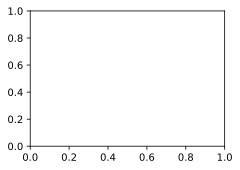

In [70]:
lr, num_epochs, device = 0.005, 3, d2l.try_gpu()
train_s2s_ch9(model, train_iter, lr, num_epochs, tgt_vocab, device)

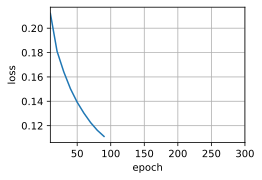

In [ ]:
num_epochs_plus=300
train_s2s_ch9(model, train_iter, lr, num_epochs_plus, tgt_vocab, device)

loss 0.076, 14314.8 tokens/sec on gpu(0)


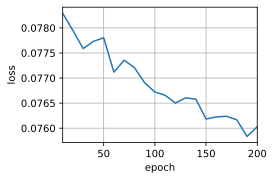

In [90]:
num_epochs_plus=200
train_s2s_ch9(model, train_iter, lr, num_epochs_plus, tgt_vocab, device)

In [ ]:
# 双向，并且加了dropout=0.1

In [159]:
embed_size,num_hiddens,num_layers,dropout,lr

(32, 32, 2, 0.1, 0.005)

In [143]:
model= build_encoder_decoder(src_vocab_size,tgt_vocab_size,embed_size,num_hiddens,num_layers,bidirectional_encoder=True,dropout=dropout)

loss 0.043, 70796.9 tokens/sec on gpu(0)


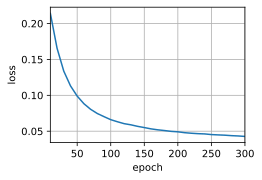

In [160]:
num_epochs_plus=300
train_s2s_ch9(model, train_iter, lr, num_epochs_plus, tgt_vocab, device)

loss 0.031, 73933.0 tokens/sec on gpu(0)


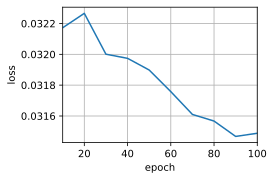

In [190]:
lr=0.001
num_epochs_plus=100
train_s2s_ch9(model, train_iter, lr, num_epochs_plus, tgt_vocab, device)

In [171]:
#@save
def predict_s2s_ch9(model, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device):
    """Predict sequences (defined in Chapter 9)."""
    #src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    src_tokens = src_vocab[get_word_list(src_sentence.lower())] + [src_vocab['<eos>']]
    enc_valid_len = np.array([len(src_tokens)], ctx=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = np.expand_dims(np.array(src_tokens, ctx=device), axis=0)
    enc_outputs = model.encoder(enc_X, enc_valid_len)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = np.expand_dims(np.array([tgt_vocab['<bos>']], ctx=device), axis=0)
    output_seq = []
    for _ in range(num_steps):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(axis=2)
        pred = dec_X.squeeze(axis=0).astype('int32').item()
        # Once the end-of-sequence token is predicted, the generation of
        # the output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq))

In [172]:
import math,collections
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    #pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    pred_tokens, label_tokens = get_word_list(pred_seq.lower()),get_word_list(label_seq.lower())
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [192]:
#@save
def translate(zh_source,en_target, model, src_vocab, tgt_vocab, num_steps, device):
    """Translate text sequences."""
    for zh, en in zip(zh_source,en_target):
        translation = predict_s2s_ch9(model, zh, src_vocab, tgt_vocab, num_steps, device)
        print(f'{zh} => {translation}, bleu {bleu(translation, en, k=2):.3f}')
zh = ['我想吃了。', '我迷茫了。', '我在家。', '他很平静。']
en = ['i want to eat .', "i was lost .", 'i\'m home .', 'he\'s calm .']

translate(zh, en, model, src_vocab, tgt_vocab, num_steps, device)

我想吃了。 => i want just just just have something many few free one eaten at free one work, bleu 0.180
我迷茫了。 => i was lost . i have lost key <unk> <unk> <unk> <unk> <unk> <unk> <unk> lost, bleu 0.334
我在家。 => i 'm at home right right right right right right right right right right right away, bleu 0.220
他很平静。 => he runs very very quiet play play play up up up from in their success working, bleu 0.000


In [193]:
zh = ["找到汤姆。","我們走吧!",'我今天感觉好多了。','我喜欢这幅画，不仅是因为它的名气，而是因为它真的是一个杰作。']
en = ['Get Tom.','Let\'s go!',"Today, I am feeling a lot better.","I like this picture, not just because it is famous, but because it really is a masterpiece."]

In [194]:
translate(zh, en, model, src_vocab, tgt_vocab, num_steps, device)

找到汤姆。 => get seeing tom guys find home view tom view out selfish sit true meet love there, bleu 0.000
我們走吧! => leave i !, bleu 0.000
我今天感觉好多了。 => i feel better good good feeling special feeling like home black bag in your view ., bleu 0.000
我喜欢这幅画，不仅是因为它的名气，而是因为它真的是一个杰作。 => "i like that <unk> really really , isn 't really really wants you really famous wife, bleu 0.000


In [189]:
a='Tom,我喜欢这幅画，不仅是因为它的名气，而是因为它真的是一个杰作。'
get_word_list(a)

['tom',
 ',',
 '我',
 '喜',
 '欢',
 '这',
 '幅',
 '画',
 '，',
 '不',
 '仅',
 '是',
 '因',
 '为',
 '它',
 '的',
 '名',
 '气',
 '，',
 '而',
 '是',
 '因',
 '为',
 '它',
 '真',
 '的',
 '是',
 '一',
 '个',
 '杰',
 '作',
 '。']

In [181]:
b="Tom, I like this picture, not just because it is famous, but because it really is a masterpiece."
get_word_list(b)

['tom',
 ',',
 'i',
 'like',
 'this',
 'picture',
 ',',
 'not',
 'just',
 'because',
 'it',
 'is',
 'famous',
 ',',
 'but',
 'because',
 'it',
 'really',
 'is',
 'a',
 'masterpiece',
 '.']